In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
# get Real data

import os
import glob
import natsort    # 파일명 정렬
import pandas as pd
import numpy as np
import math
import copy
 
# path = '/content/gdrive/MyDrive/Colab Notebooks/eye_writing_data/csv_preprocessed_data/01/'
path_for_glob = '/home/donghyun/eye/csv_preprocessed_data/*'

# file_list = os.listdir(path)                            # 파일명 만
file_path_list = glob.glob(path_for_glob)                 # 경로 전체

sorted_file_path_list = natsort.natsorted(file_path_list)     # str 파일 숫자로 정렬 함수
print(sorted_file_path_list)
 
raw_data_list = []
file_names_list = []

for i in range(len(sorted_file_path_list)):

  file_names = os.listdir(sorted_file_path_list[i])
  file_names = natsort.natsorted(file_names)
  file_names_list.extend(file_names)
  # print(file_names)

  temp_list = []
  for each_file in file_names :
  
    raw_data = pd.read_csv(sorted_file_path_list[i] +'/'+ each_file , header=None)
    raw_data = raw_data.values.tolist()

    temp_raw_data_list = []
    for coor in raw_data:
      temp_raw_data = [round(coor[0],6), round(coor[1],6)]
      temp_raw_data_list.append(temp_raw_data)
  
    temp_list.append(temp_raw_data_list)

  raw_data_list.append(temp_list)
  

In [ ]:
## get Reference data

Reference_data_path = '/home/donghyun/eye/csv_Reference_data/preprocessed_Reference_data/*'

Reference_file_path_list = glob.glob(Reference_data_path)                 # 경로 전체

sorted_Reference_file_path_list = natsort.natsorted(Reference_file_path_list)     # str 파일 숫자로 정렬 함수
print(sorted_Reference_file_path_list)

Reference_data_list = []
for i in range(len(sorted_Reference_file_path_list)):
  Reference_data = pd.read_csv(sorted_Reference_file_path_list[i], header=None)
  Reference_data = Reference_data.values.tolist()
  Reference_data_list.append(Reference_data)


['/home/donghyun/eye/csv_answer_data/preprocessed_answer_data/0.csv', '/home/donghyun/eye/csv_answer_data/preprocessed_answer_data/1.csv', '/home/donghyun/eye/csv_answer_data/preprocessed_answer_data/2.csv', '/home/donghyun/eye/csv_answer_data/preprocessed_answer_data/3.csv', '/home/donghyun/eye/csv_answer_data/preprocessed_answer_data/4.csv', '/home/donghyun/eye/csv_answer_data/preprocessed_answer_data/5.csv', '/home/donghyun/eye/csv_answer_data/preprocessed_answer_data/6.csv', '/home/donghyun/eye/csv_answer_data/preprocessed_answer_data/7.csv', '/home/donghyun/eye/csv_answer_data/preprocessed_answer_data/8.csv', '/home/donghyun/eye/csv_answer_data/preprocessed_answer_data/9.csv']


In [ ]:
raw_data = np.array(raw_data_list)
print(raw_data.shape)

Reference_data = np.array(Reference_data_list)
print(Reference_data.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Activation, Input, LSTM
from tensorflow.keras.layers import Dense, Dropout, Add
from tensorflow.keras.layers import MaxPooling1D, Lambda, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from attention import Attention

def binary_siamese_net(input_shape, base_model):
  left_input = Input(input_shape, name= "Left Input")
  right_input = Input(input_shape, name= "Right Input")

  encoded_left = base_model(left_input)
  encoded_right = base_model(right_input)

  L1_layer = Lambda(lambda tensor: K.abs(tensor[0]-tensor[1]))
  L1_distance = L1_layer([encoded_left,encoded_right])

  prediction = Dense(1,activation = 'sigmoid',name = "Dense")(L1_distance)

  siamese_net = Model(inputs = [left_input, right_input], outputs = prediction)

  return siamese_net


def base_model_v21(input_shape):
    X_input = Input(input_shape, name = "Input")

    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(64, kernel_size = 3, strides = 1, activation='relu',name = "Conv_1")(X_input)    # CONV1D
    X = BatchNormalization(name = "Conv_1_Batch_norm")(X)                                                 # Batch normalization
    X = Dropout(rate = 0.2, name = "Conv_1_Dropout")(X)                                                  # dropout (use 0.8)

    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(64, kernel_size = 3, strides = 1, activation='relu',name = "Conv_2")(X)          # CONV1D
    X = BatchNormalization(name = "Conv_2_Batch_norm")(X)                                                 # Batch normalization
    X = Dropout(rate = 0.2,name = "Conv_2_Dropout")(X)                                                  # dropout (use 0.8)

    # Step 4: First LSTM Layer (≈4 lines)
    X = LSTM(units = 64, return_sequences = True, name = "LSTM_1")(X)                            # LSTM (use 128 units and return the sequences)
    X = BatchNormalization(name = "LSTM_1_Batch_norm")(X)                                                 # Batch normalization
    X = Dropout(rate = 0.2,name = "LSTM_1_Dropout")(X)                                                  # dropout (use 0.8)
    
    # Step 5: Third LSTM Layer (≈4 lines)
    X = LSTM(units = 64, return_sequences = True, name = "LSTM_2")(X)                                                     # LSTM (use 128 units and return the sequences)
    X = Attention(32)(X)
    X = BatchNormalization(name = "LSTM_2_Batch_norm")(X)                                                 # Batch normalization
    X = Dropout(rate = 0.2,name = "LSTM_2_Dropout")(X)                                                  # dropout (use 0.8)
    
    X = Dense(128)(X)

    base_model = Model(inputs = X_input, outputs = X)

    return base_model

def base_model_v21_without_attention(input_shape):
    X_input = Input(input_shape)

    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(64, kernel_size = 3, strides = 1, activation='relu')(X_input)    # CONV1D
    X = BatchNormalization()(X)                                                 # Batch normalization
    X = Dropout(rate = 0.2)(X)                                                  # dropout (use 0.8)

    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(64, kernel_size = 3, strides = 1, activation='relu')(X)          # CONV1D
    X = BatchNormalization()(X)                                                 # Batch normalization
    X = Dropout(rate = 0.2)(X)                                                  # dropout (use 0.8)

    # Step 4: First LSTM Layer (≈4 lines)
    X = LSTM(units = 64, return_sequences = True)(X)                            # LSTM (use 128 units and return the sequences)
    X = Dropout(rate = 0.2)(X)                                                  # dropout (use 0.8)
    X = BatchNormalization()(X)                                                 # Batch normalization

    # Step 5: Third LSTM Layer (≈4 lines)
    X = LSTM(units = 64)(X)                                                     # LSTM (use 128 units and return the sequences)
#     X = Attention(32)(X)
    X = Dropout(rate = 0.2)(X)                                                  # dropout (use 0.8)
    X = BatchNormalization()(X)                                                 # Batch normalization
    
    X = Dense(128)(X)

    base_model = Model(inputs = X_input, outputs = X)

    return base_model


print('success')

success


In [ ]:
K.clear_session()

In [ ]:
input_shape = (190,2)

base_model = base_model_v21(input_shape) 
model = binary_siamese_net(input_shape,base_model)

optimizer = Adam(learning_rate = 0.001)

model.compile(loss = "binary_crossentropy", optimizer = optimizer)

# base_model.summary()
model.summary()

In [ ]:
# utils

def divide_data_set(data_set):

  raw_data_set = copy.deepcopy(data_set)

#  raw_data_set = raw_data_set[:len(raw_data_set)-1]  # 0~8만 추출

  train_set = []
  test_set = []

  for label in range(len(raw_data_set)):
    
    # n/m random choice
    extract_index = []
    while len(extract_index) < int(len(raw_data_set[label])* (1/3) ):
      id = np.random.randint(0,len(raw_data_set[label]))
      if id not in extract_index:
        extract_index.append(id)
    
    sampling_test_list = []
    for id in extract_index:
      sampling_test_list.append(raw_data_set[label][id])
    
    sampling_train_list = [x for x in raw_data_set[label] if x not in sampling_test_list]
    
    train_set.append(sampling_train_list)
    test_set.append(sampling_test_list)

  return train_set, test_set

#### Train pair Comparison batch consisting of only Real data

def get_Train_pair_only_Real_data(train_set, batch_size):
  '''
  Train_pair[0] : Real data batch
  Train_pair[1] : Comparison batch with Real data
  '''

  Real_data = copy.deepcopy(train_set)

  Real_data = np.array(Real_data)

  classes, elements_num, length, coor_shape = Real_data.shape

  categories = np.random.choice(classes, size=(classes,), replace = False)
  categories = np.append(categories, np.random.choice(classes, size=(batch_size - classes,), replace = False))  # 20개가 기본

  Train_pair = [np.zeros((batch_size, length, coor_shape)) for i in range(2)]

  targets = np.zeros((batch_size,))
  targets[batch_size // 2:] = 1
  # print(targets)

  for i in range(batch_size):
    # print('i : {}'.format(i))
    Real_data_batch_category = categories[i]

    Real_data_batch_index = np.random.randint(0,elements_num)
    Comparison_batch_index = np.random.randint(0,elements_num)

    Train_pair[0][i,:,:] = Real_data[Real_data_batch_category, Real_data_batch_index].reshape(length,coor_shape)
    # print('Real_data_batch_category : {}'.format(Real_data_batch_category))
    # print('Real_data_batch_index : {}'.format(Real_data_batch_index))

    if i >= batch_size // 2 :
      Comparison_batch_category = Real_data_batch_category
    else :
      Comparison_batch_category = (Real_data_batch_category + np.random.randint(1,classes)) % classes

    Train_pair[1][i,:,:] = Real_data[Comparison_batch_category, Comparison_batch_index].reshape(length, coor_shape)
    # print('Comparison_batch_category : {}'.format(Comparison_batch_category))
    # print('Comparison_batch_index : {}'.format(Comparison_batch_index))

  return Train_pair, targets


### Train pair Comparison batch consisting of only Reference data

def get_Train_pair_only_Refernece_data(train_set, Reference_data, batch_size):
  '''
  Train_pair[0] : Real data batch
  Train_pair[1] : Comparison batch with Reference data
  '''
  
  Real_data = copy.deepcopy(train_set)

  Real_data = np.array(Real_data)

  classes, elements_num, length, coor_shape = Real_data.shape
  Reference_classes, Reference_length, Reference_coor_shape = np.array(Reference_data).shape
  
  categories = np.random.choice(classes, size=(classes,), replace = False)  ## 최대 20개 까지 가능
  categories = np.append(categories, np.random.choice(classes, size=(batch_size - classes,), replace = False))

#   print('categories : {}'.format(categories))

  Train_pair = [np.zeros((batch_size, length, coor_shape)) for i in range(2)]

  targets = np.zeros((batch_size,))
  targets[batch_size // 2:] = 1
#   print(targets)

  for i in range(batch_size):
    Real_data_batch_category = categories[i]

    Real_data_batch_index = np.random.randint(0,elements_num)
    Comparison_batch_index = np.random.randint(0,elements_num)
    
    Train_pair[0][i,:,:] = Real_data[Real_data_batch_category, Real_data_batch_index].reshape(length,coor_shape)
#     print('Real_data_batch_category : {}'.format(Real_data_batch_category))
#     print('Real_data_batch_index : {}'.format(Real_data_batch_index))

    if i >= batch_size // 2 :
      Comparison_batch_category = Real_data_batch_category
      Train_pair[1][i,:,:] = Reference_data[Comparison_batch_category].reshape(Reference_length, Reference_coor_shape)
    else :
      Comparison_batch_category = (Real_data_batch_category + np.random.randint(1,Reference_classes)) % classes
      Train_pair[1][i,:,:] = Reference_data[Comparison_batch_category].reshape(Reference_length, Reference_coor_shape)
      
#     print('Comparison_batch_category : {}'.format(Comparison_batch_category))
#     print('Comparison_batch_index : {}'.format(Comparison_batch_index))

  return Train_pair, targets

### Train pair Comparison batch consisting of Real data & Reference data

def get_input_batch_with_Mix_data(train_set, Reference_data, batch_size, cv=None):
  '''
  Train_pair[0] : Real data batch
  Train_pair[1] : Comparison batch with Real data and Reference data (mix)
  '''
   
  Real_data = copy.deepcopy(train_set)
  Real_data = np.array(Real_data)

  classes, elements_num, length, coor_shape = Real_data.shape
  Reference_classes, Reference_length, Reference_coor_shape = np.array(Reference_data).shape
  
  categories = np.random.choice(classes, size=(classes,), replace = False)  ## 최대 20개 까지 가능
  categories = np.append(categories, np.random.choice(classes, size=(batch_size - classes,), replace = False))

#   print('categories : {}'.format(categories))

  Train_pair = [np.zeros((batch_size, length, coor_shape)) for i in range(2)]

  targets = np.zeros((batch_size,))
  targets[batch_size // 2:] = 1
#   print(targets)

  for i in range(batch_size):
#     print('i : {}'.format(i))
    Real_data_batch_category = categories[i]

    Real_data_batch_index = np.random.randint(0,elements_num)
    Comparison_batch_index = np.random.randint(0,elements_num)
    
    Train_pair[0][i,:,:] = Real_data[Real_data_batch_category, Real_data_batch_index].reshape(length,coor_shape)
#     print('Real_data_batch_category : {}'.format(Real_data_batch_category))
#     print('Real_data_batch_index : {}'.format(Real_data_batch_index))

    if i >= batch_size // 2 :
      Comparison_batch_category = Real_data_batch_category
      Train_pair[1][i,:,:] = Reference_data[Comparison_batch_category].reshape(Reference_length, Reference_coor_shape)
        
    else :
      Comparison_batch_category = (Real_data_batch_category + np.random.randint(1,classes)) % classes
      Train_pair[1][i,:,:] = Real_data[Comparison_batch_category, Comparison_batch_index].reshape(length, coor_shape)
      
#     print('Comparison_batch_category : {}'.format(Comparison_batch_category))
#     print('Comparison_batch_index : {}'.format(Comparison_batch_index))

  return Train_pair, targets

### Test pair

def get_Test_pair(test_set, Reference_data, label, each):
  '''
  Test_pair[0] : Same test data
  Test_pair[1] : All of Reference data (sequential)
  '''

  test_data = copy.deepcopy(test_set)
  test_array = np.array(test_data)

  classes, elements, length, coor_shape = test_array.shape
  
  Reference_classes, Reference_length, Reference_coor_shape = np.array(Reference_data).shape

  categories = np.random.choice(range(classes), size = (classes,), replace = False)
#   print('categories : {}'.format(categories))
#   print('label : {}'.format(label))

  Test_pair = [np.zeros((classes, length, coor_shape)) for i in range(2)]

  Comparison_batch_index = label
  Comparison_batch_elements = each
#   Comparison_batch_elements = np.random.randint(0,elements)

#   print('Comparison_batch_index : {}'.format(Comparison_batch_index))
#   print('Comparison_batch_elements : {}'.format(Comparison_batch_elements))

  targets = np.zeros((classes,))
  targets[Comparison_batch_index] = 1
#   print('targets : {}'.format(targets))
    
  for i in range(classes):
#     print('i : {}'.format(i))
    Test_pair[0][i,:,:] = test_array[label, Comparison_batch_elements].reshape(length,coor_shape)
#     print('label : {}'.format(label))

    category = categories[i]
#     print('categories : {}'.format(categories))
#     print('category : {}'.format(category))

    Comparison_batch_category = i
    Test_pair[1][i,:,:] = Reference_data[i].reshape(Reference_length, Reference_coor_shape)
#     print('Comparison_batch_category : {}'.format(Comparison_batch_category))
    
  return Test_pair, targets

#### Siamese trainer & tester 

def Siamese_trainer(model, train_set, Reference_data, batch_size, EPOCH):
  train_set = copy.deepcopy(train_set)
  
  steps = 0
  for epoch in range(0,EPOCH):
    steps = steps + 1

    if epoch % 2 == 0 :
        train_inputs, targets = get_Train_pair_only_Real_data(train_set, batch_size)
    else :
        train_inputs, targets = get_Train_pair_only_Refernece_data(train_set, Reference_data, batch_size)

    # if epoch % 2 == 0 :
    #     train_inputs, targets = get_Train_pair_only_Real_data(train_set, batch_size)
    # else :
    #     train_inputs, targets = get_input_batch_with_Mix_data(train_set, Reference_data, batch_size)

    train_loss = model.train_on_batch(train_inputs, targets)
    
  return train_loss


def Siamese_tester(model, test_set, Reference_data, steps=100):
  test_data = copy.deepcopy(test_set)

  test_array = np.array(test_data)

  average = []
  for label in range(0,10):     # 0~9
    steps = len(test_set[label])
    correct = 0
    
    for i in range(0,steps):  
      Test_pair, targets = get_Test_pair(test_data, Reference_data, label, i)        
      
      probs = model.predict_on_batch(Test_pair)

#       print(probs)
#       print(targets)
#       print("np.argmax(probs) = {}, np.argmax(targets) = {}".format(np.argmax(probs),np.argmax(targets)))
      
      if np.argmax(probs) == np.argmax(targets):
          correct += 1

    correct_persent = (100.0 * correct / steps )
    average.append(correct_persent)
    
    print("{} class's accuracy : {:.2f} % ({}/{})".format(label,correct_persent,correct, steps))

  test_acc = np.mean(np.array(average))
  print("accuracy average : {:.2f} % \n".format(test_acc))

  return test_acc


def Siamese_tester_ensemble_ver(model_list, test_set, Reference_data, steps=100):
  test_data = copy.deepcopy(test_set)

  test_array = np.array(test_data)

  average = []
  for label in range(0,10):   # 0~9
    steps = len(test_set[label])
    correct = 0
    
    for i in range(0,steps):  
      Test_pair, targets = get_test_batch_with_Reference_data(test_data, Reference_data, label, i)        
      
      y = np.zeros(shape = (10,1), dtype = np.float32)
      for model in model_list:
        probs = model.predict_on_batch(Test_pair)       
        print(probs)
        
        y += probs
        # print(y)
        # print("np.argmax(y) = {}, np.argmax(targets) = {}".format(np.argmax(y),np.argmax(targets)))
    
      if np.argmax(y) == np.argmax(targets):
        correct += 1
    
    correct_persent = (100.0 * correct / steps )
    average.append(correct_persent)
    
    print("{} class's accuracy : {:.2f} % ({}/{})".format(label,correct_persent,correct, steps))

  test_acc = np.mean(np.array(average))
  print("accuracy average : {:.2f} % \n".format(test_acc))

  return test_acc

print('success')

success


In [ ]:
### Visualization 

import matplotlib.pyplot as plt

def plot_images(input_list):        # input_list plot 함수

  fig,axes = plt.subplots(4,5, figsize=(10,10))
  # fig,axes = plt.subplots(2,5, figsize=(5,10))

  row, col = axes.shape

  n = 0
  for r in range(row):
    for c in range(col):
         
      x,y = zip(*input_list[n])
      max_val = 1

      axes[r][c].set_xlim([math.floor(-max_val)*1.2,math.ceil(max_val)*1.2])
      axes[r][c].set_ylim([math.floor(-max_val)*1.2,math.ceil(max_val)*1.2])
 
      axes[r][c].scatter(x,y, 1)
      if r >= 2 :
        axes[r][c].scatter(x,y, 1, color='red')
 
      axes[r][c].set_xticks([])
      axes[r][c].set_yticks([])

      n += 1

  fig.tight_layout

In [ ]:
train_set, test_set = divide_data_set(raw_data_list)

print(np.array(train_set).shape)
print(np.array(test_set).shape)

(9, 36, 190, 2)
(9, 18, 190, 2)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


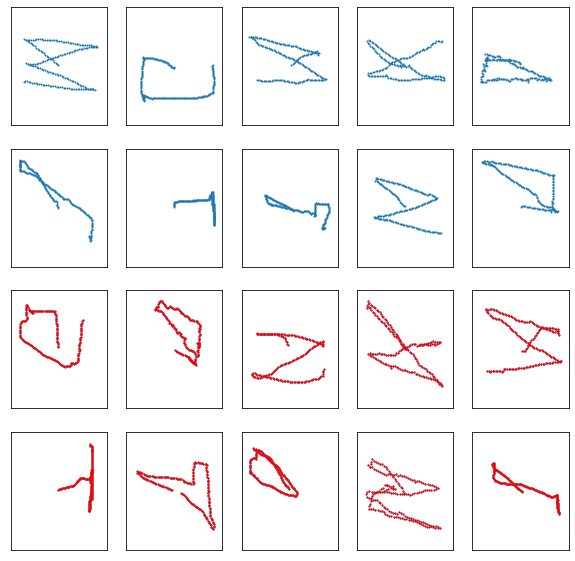

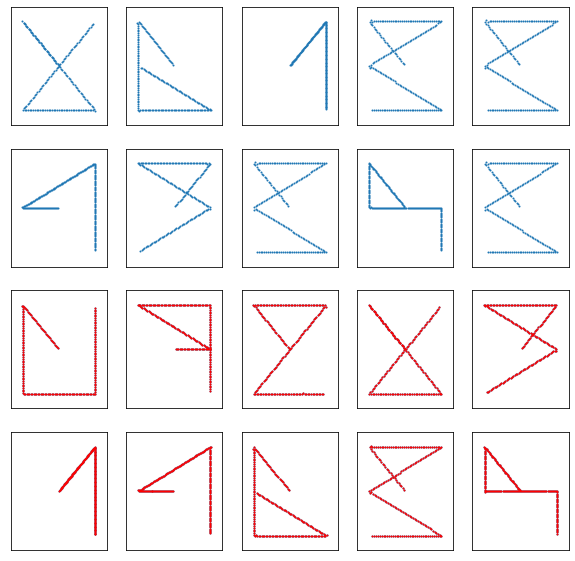

In [ ]:
g, t = get_Train_pair_only_Refernece_data(train_set,answer_data,20)
# g, t = get_Train_pair_only_Real_data(train_set,answer_data,20)
# g, t = get_Train_pair_only_Mix_data(train_set,answer_data,20)

g_array = np.array(g)
print(t)
plot_images(g_array[0])
plot_images(g_array[1])

# g, t = get_Test_pair(test_set,answer_data,2,9)
# g_array = np.array(g)

# print(t)
# plot_images(g_array[0])
# plot_images(g_array[1])

In [ ]:
# Basic Train

K.clear_session()
input_shape = (190,2)

base_model = base_model_v21(input_shape) 
model = binary_siamese_net(input_shape,base_model)

optimizer = Adam(learning_rate = 0.001)

model.compile(loss = "binary_crossentropy", optimizer = optimizer)

model.summary()

weights_path = '/home/donghyun/eye/random_choice/random_choice_step1_weights.h5'
best_acc = 70

train_set, test_set = divide_data_set(raw_data_list)

# model.load_weights(weights_path)

for i in range(100):
    print('{} steps'.format(i+1))
    
    batch_size = 20
    EPOCH = 200

    Siamese_trainer(model, train_set, Reference_data, batch_size, EPOCH)
    
    test_acc = Siamese_tester(model, test_set, Reference_data)
    
    if test_acc >= best_acc:
        model.save_weights(weights_path)
        best_acc = test_acc
        
    print('best accuracy : {:.2f} % \n'.format(best_acc))

In [ ]:
train_set, test_set = divide_data_set(raw_data_list)

print(np.array(train_set).shape)
print(np.array(test_set).shape)

(9, 36, 190, 2)
(9, 18, 190, 2)


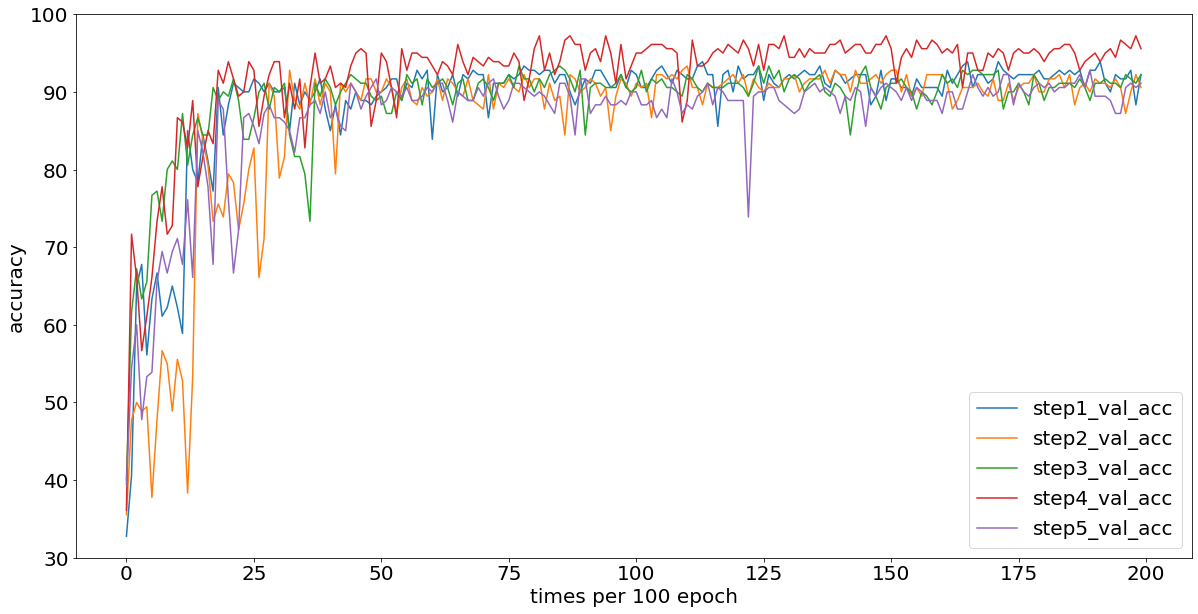

In [ ]:
## get epoch (train & validation)

fig, ax = plt.subplots(figsize = (20,10))

# ax.plot(step1_test_acc_list, step2_test_acc_list, step3_test_acc_list, step4_test_acc_list, step5_test_acc_list)
ax.plot(step1_test_acc_list)
ax.plot(step2_test_acc_list)
ax.plot(step3_test_acc_list)
ax.plot(step4_test_acc_list)
ax.plot(step5_test_acc_list)

ax.set_ylim(30, 100)
# plt.xticks([1, 2, 3, 4, 5],
#            ['case 1', 'case 2', 'case 3', 'case 4', 'case 5'],fontsize = 12)
ax.set_xlabel('times per 100 epoch',fontsize = 20)
ax.set_ylabel('accuracy',fontsize = 20)

ax.legend(['step1_val_acc', 'step2_val_acc', 'step3_val_acc', 'step4_val_acc', 'step5_val_acc'], loc='lower right', fontsize = '20')

plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')

plt.show()

In [ ]:
## ensemble model

from tensorflow.keras.models import load_model

K.clear_session()
input_shape = (190,2)

base_model_1 = base_model_v21(input_shape) 
base_model_2 = base_model_v21(input_shape) 
base_model_3 = base_model_v21(input_shape) 
base_model_4 = base_model_v21(input_shape) 
base_model_5 = base_model_v21(input_shape) 

model_1 = binary_siamese_net(input_shape,base_model_1)
model_2 = binary_siamese_net(input_shape,base_model_2)
model_3 = binary_siamese_net(input_shape,base_model_3)
model_4 = binary_siamese_net(input_shape,base_model_4)
model_5 = binary_siamese_net(input_shape,base_model_5)

weights_path1 = '/home/donghyun/eye/random_choice/random_choice_step1_weights.h5'
weights_path2 = '/home/donghyun/eye/random_choice/random_choice_step2_weights.h5'
weights_path3 = '/home/donghyun/eye/random_choice/random_choice_step3_weights.h5'
weights_path4 = '/home/donghyun/eye/random_choice/random_choice_step4_weights.h5'
weights_path5 = '/home/donghyun/eye/random_choice/random_choice_step5_weights.h5'

model_1.load_weights(weights_path1)
model_2.load_weights(weights_path2)
model_3.load_weights(weights_path3)
model_4.load_weights(weights_path4)
model_5.load_weights(weights_path5)

model_1.summary()

model_list = [model_1, model_2, model_3, model_4, model_5]

test_acc = Siamese_tester_ensemble_ver(model_list, test_set, Reference_data)
